# Synthetic experiments

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import datetime

np.random.seed(0)
print(optuna.__version__)

3.6.0


## 0. Generating synthetic data

In [136]:
x = np.random.rand(10000, 4)
r0 = np.random.normal(0, 1, 10000)
r1 = 1 * x[:, 1] + 1 * x[:, 2] + np.random.normal(0, 1, 10000)

## 1. Evaluation policy $\pi_{e,1}$

In [137]:
def pi(x, pi_list, pi_prob):
    a_pi1 = np.array([np.random.rand(len(x)) < x[:, 0]])
    a_pi2 = np.array([x[:, 1] >= 0.5])
    a_pi3 = np.array([x[:, 2] >= 0.5])
    a = np.where(pi_list == 1, a_pi1, np.where(pi_list == 2, a_pi2, a_pi3))[0]
    w = x[:, 0] * pi_prob[0] + np.where(x[:, 1] >= 0.5, 1, 0) * pi_prob[1] + np.where(x[:, 2] >= 0.5, 1, 0) * pi_prob[2]
    return a, w


def calc_revenue(a, r0, r1):
    r = np.where(a, r1, r0)
    return r.mean()


def calc_eval(a, w, r0, r1, x, eval_policy):
    if eval_policy == 'ep1':
        ep_a = np.random.rand(len(x)) < np.where(x[:, 1] >= 0.5, 0.8, 0.2)
        ep_w = np.where(x[:, 1] >= 0.5, 0.8, 0.2)
    elif eval_policy == 'ep2':
        ep_a = np.random.rand(len(x)) < np.where(x[:, 1] >= 0.5, 0.8, 0.2)
        ep_w = np.where(x[:, 1] >= 0.5, 0.2, 0.8)
    eval_r = np.where(a, r1, 0) * (ep_w / w) + np.where(a, 0, r0) * ((1 - ep_w) / (1 - w))
    truth_r = np.where(ep_a, r1, r0)
    return np.mean(np.square(eval_r - truth_r))


def object(trial):
    eval_policy = 'ep1'
    pi1_prob = trial.suggest_float('pi1_prob', 0.01, 1)
    pi2_prob = trial.suggest_float('pi2_prob', 0, 1-pi1_prob)
    pi3_prob = 1 - pi1_prob - pi2_prob
    pi_prob = [pi1_prob, pi2_prob, pi3_prob]
    pi_list = np.random.choice([1, 2, 3], size=len(x), p=pi_prob)
    a, w = pi(x, pi_list, pi_prob)
    rev_obj = calc_revenue(a, r0, r1)
    eval_obj =  calc_eval(a, w, r0, r1, x, eval_policy)
    return rev_obj, eval_obj


study = optuna.create_study(directions=['maximize', 'minimize'], sampler=optuna.samplers.NSGAIISampler(seed=0))
optuna.logging.disable_default_handler()
study.optimize(object, n_trials=1000)

In [138]:
optuna.visualization.plot_pareto_front(study, include_dominated_trials=True)

In [139]:
optuna.visualization.plot_slice(
    study,
    target=lambda t: t.values[0],
    target_name="Revenue performance",
).show()

In [140]:
optuna.visualization.plot_slice(
    study,
    target=lambda t: t.values[1],
    target_name="Mean squared error of off-policy evaluation",
).show()

In [141]:
df = study.trials_dataframe()

In [142]:
extract_col = ['number', 'params_pi1_prob', 'params_pi2_prob', 'values_0', 'values_1']
now = datetime.datetime.now()
now = now.strftime('%Y%m%d%H%M%S')
df[extract_col].to_csv('results/optuna_result_{}.csv'.format(now))

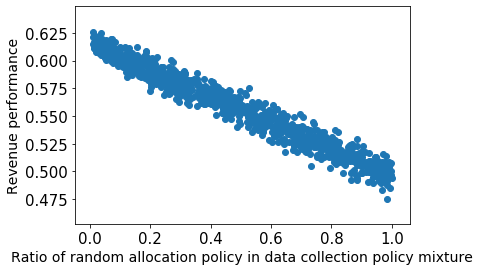

In [143]:
plt.scatter(df['params_pi1_prob'], df['values_0'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('results/revenue_synthetic_1.pdf', bbox_inches='tight')

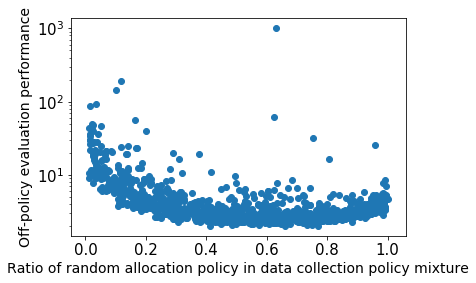

In [144]:
# markerサイズを変更
plt.scatter(df['params_pi1_prob'], df['values_1'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Off-policy evaluation performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.savefig('results/ope_synthetic_1.pdf', bbox_inches='tight')

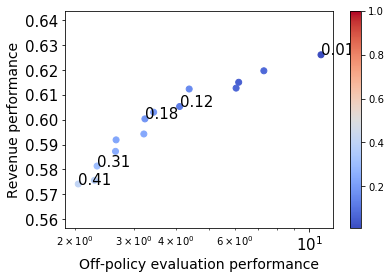

In [145]:
dominates = [False]*len(df)
values_0 = list(df['values_0'])
values_1 = list(df['values_1'])

for i in range(len(df)):
    for j in range(len(df)):
        if i == j:
            continue
        if dominates[j] == True:
            continue
        if values_0[j] >= values_0[i] and values_1[j] <= values_1[i]:
            dominates[i] = True
            break 
df['dominates'] = dominates
dom_df = df.query('dominates == False').copy()
dom_df.sort_values('values_0', inplace=True) 
dom_df.reset_index(drop=True, inplace=True)
plt.scatter(dom_df['values_1'], dom_df['values_0'], c=dom_df['params_pi1_prob'], cmap='coolwarm')
plt.clim(0.01, 1)
plt.colorbar()
plt.xlabel('Off-policy evaluation performance', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
max_idx = 0
min_idx = len(dom_df) - 1 
q1_idx = len(dom_df) // 4 - 1
q2_idx = len(dom_df) // 2 - 1
q3_idx = len(dom_df) // 4 * 3 - 1
plt.text(dom_df['values_1'][max_idx] , dom_df['values_0'][max_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][max_idx]), fontsize=15)
plt.text(dom_df['values_1'][min_idx] , dom_df['values_0'][min_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][min_idx]), fontsize=15)
plt.text(dom_df['values_1'][q1_idx] , dom_df['values_0'][q1_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q1_idx]), fontsize=15)
plt.text(dom_df['values_1'][q2_idx] , dom_df['values_0'][q2_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q2_idx]), fontsize=15)
plt.text(dom_df['values_1'][q3_idx] , dom_df['values_0'][q3_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q3_idx]), fontsize=15)
plt.savefig('results/curve_synthetic_1.pdf', bbox_inches='tight')

In [146]:
dom_df

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_pi1_prob,params_pi2_prob,system_attrs_nsga2:generation,state,dominates
0,756,0.574108,2.042800,2024-05-23 12:18:02.102697,2024-05-23 12:18:02.103831,0 days 00:00:00.001134,0.410726,0.354317,15,COMPLETE,False
1,424,0.575582,2.283655,2024-05-23 12:18:01.714122,2024-05-23 12:18:01.715078,0 days 00:00:00.000956,0.379776,0.319811,8,COMPLETE,False
2,375,0.581331,2.324312,2024-05-23 12:18:01.664190,2024-05-23 12:18:01.665122,0 days 00:00:00.000932,0.307400,0.380584,7,COMPLETE,False
3,215,0.587242,2.638467,2024-05-23 12:18:01.508621,2024-05-23 12:18:01.509470,0 days 00:00:00.000849,0.249004,0.497538,4,COMPLETE,False
4,751,0.591865,2.648874,2024-05-23 12:18:02.096294,2024-05-23 12:18:02.097512,0 days 00:00:00.001218,0.229606,0.380533,15,COMPLETE,False
5,496,0.594243,3.205174,2024-05-23 12:18:01.790400,2024-05-23 12:18:01.791381,0 days 00:00:00.000981,0.237272,0.386599,9,COMPLETE,False
6,286,0.600315,3.228757,2024-05-23 12:18:01.575243,2024-05-23 12:18:01.576128,0 days 00:00:00.000885,0.183024,0.317914,5,COMPLETE,False
7,408,0.603011,3.428424,2024-05-23 12:18:01.698085,2024-05-23 12:18:01.699016,0 days 00:00:00.000931,0.191203,0.325966,8,COMPLETE,False
8,947,0.605303,4.097424,2024-05-23 12:18:02.389968,2024-05-23 12:18:02.391295,0 days 00:00:00.001327,0.121624,0.490494,18,COMPLETE,False
9,967,0.612356,4.376074,2024-05-23 12:18:02.426065,2024-05-23 12:18:02.427862,0 days 00:00:00.001797,0.156558,0.694988,19,COMPLETE,False


## 2. Evaluation policy $\pi_{e,2}$

In [147]:
def pi(x, pi_list, pi_prob):
    a_pi1 = np.array([np.random.rand(len(x)) < x[:, 0]])
    a_pi2 = np.array([x[:, 1] >= 0.5])
    a_pi3 = np.array([x[:, 2] >= 0.5])
    a = np.where(pi_list == 1, a_pi1, np.where(pi_list == 2, a_pi2, a_pi3))[0]
    w = x[:, 0] * pi_prob[0] + np.where(x[:, 1] >= 0.5, 1, 0) * pi_prob[1] + np.where(x[:, 2] >= 0.5, 1, 0) * pi_prob[2]
    return a, w


def calc_revenue(a, r0, r1):
    r = np.where(a, r1, r0)
    return r.mean()


def calc_eval(a, w, r0, r1, x, eval_policy):
    if eval_policy == 'ep1':
        ep_a = np.random.rand(len(x)) < x[:, 3]
        ep_w = x[:, 3]
    elif eval_policy == 'ep2':
        ep_a = np.random.rand(len(x)) < np.where(x[:, 1] >= 0.5, 0.8, 0.2)
        ep_w = np.where(x[:, 1] >= 0.5, 0.8, 0.2)
    # 収集方策の a = 1 のとき、r1 を観測していて、(ep_w[ips_match] / w[ips_match]) だけ重みをかける
    # 収集方策の a = 0 のとき、r0 を観測していて、(1 - ep_w[ips_match]) / (1 - w[ips_match]) だけ重みをかける
    eval_r = np.where(a, r1, 0) * (ep_w / w) + np.where(a, 0, r0) * ((1 - ep_w) / (1 - w))
    truth_r = np.where(ep_a, r1, r0)
    return np.mean(np.square(eval_r - truth_r))


def object(trial):
    eval_policy = 'ep2'
    pi1_prob = trial.suggest_float('pi1_prob', 0.01, 1)
    pi2_prob = trial.suggest_float('pi2_prob', 0, 1-pi1_prob)
    pi3_prob = 1 - pi1_prob - pi2_prob
    pi_prob = [pi1_prob, pi2_prob, pi3_prob]
    pi_list = np.random.choice([1, 2, 3], size=len(x), p=pi_prob)
    a, w = pi(x, pi_list, pi_prob)
    rev_obj = calc_revenue(a, r0, r1)
    eval_obj =  calc_eval(a, w, r0, r1, x, eval_policy)
    return rev_obj, eval_obj


study = optuna.create_study(directions=['maximize', 'minimize'], sampler=optuna.samplers.NSGAIISampler(seed=0))
optuna.logging.disable_default_handler()
study.optimize(object, n_trials=1000)

In [148]:
optuna.visualization.plot_pareto_front(study, include_dominated_trials=False)

In [149]:
optuna.visualization.plot_slice(
    study,
    target=lambda t: t.values[0],
    target_name="Revenue performance",
).show()

In [150]:
optuna.visualization.plot_slice(
    study,
    target=lambda t: t.values[1],
    target_name="Mean squared error of off-policy evaluation",
).show()

In [151]:
df = study.trials_dataframe()

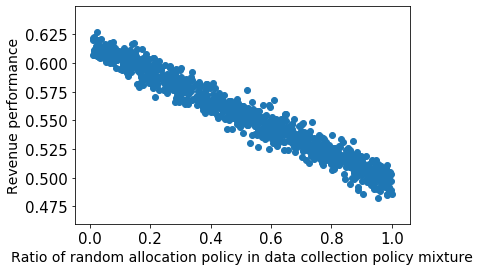

In [152]:
plt.scatter(df['params_pi1_prob'], df['values_0'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('results/revenue_synthetic_2.pdf', bbox_inches='tight')

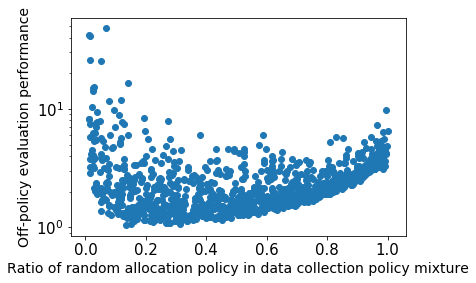

In [159]:
plt.scatter(df['params_pi1_prob'], df['values_1'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Off-policy evaluation performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.savefig('results/ope_synthetic_2.pdf', bbox_inches='tight')

In [154]:
df

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_pi1_prob,params_pi2_prob,system_attrs_nsga2:generation,state
0,0,0.548512,1.572501,2024-05-23 12:18:03.723760,2024-05-23 12:18:03.724991,0 days 00:00:00.001231,0.553325,0.319457,0,COMPLETE
1,1,0.548461,1.620431,2024-05-23 12:18:03.725301,2024-05-23 12:18:03.726808,0 days 00:00:00.001507,0.606736,0.214283,0,COMPLETE
2,2,0.569154,1.523192,2024-05-23 12:18:03.726954,2024-05-23 12:18:03.727846,0 days 00:00:00.000892,0.429418,0.368535,0,COMPLETE
3,3,0.572248,1.269352,2024-05-23 12:18:03.727979,2024-05-23 12:18:03.728804,0 days 00:00:00.000825,0.443211,0.496529,0,COMPLETE
4,4,0.510010,3.731720,2024-05-23 12:18:03.728887,2024-05-23 12:18:03.729636,0 days 00:00:00.000749,0.964026,0.013794,0,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
995,995,0.596108,1.332077,2024-05-23 12:18:05.021032,2024-05-23 12:18:05.022291,0 days 00:00:00.001259,0.181461,0.716385,19,COMPLETE
996,996,0.611310,1.900050,2024-05-23 12:18:05.022417,2024-05-23 12:18:05.023662,0 days 00:00:00.001245,0.037377,0.635657,19,COMPLETE
997,997,0.561225,1.228747,2024-05-23 12:18:05.023789,2024-05-23 12:18:05.025068,0 days 00:00:00.001279,0.420294,0.458710,19,COMPLETE
998,998,0.528163,2.043710,2024-05-23 12:18:05.025202,2024-05-23 12:18:05.026496,0 days 00:00:00.001294,0.723986,0.132516,19,COMPLETE


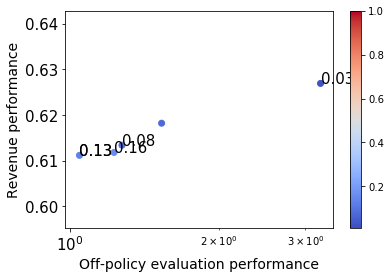

In [157]:
dominates = [False]*len(df)
values_0 = list(df['values_0'])
values_1 = list(df['values_1'])

for i in range(len(df)):
    for j in range(len(df)):
        if i == j:
            continue
        if dominates[j] == True:
            continue
        if values_0[j] >= values_0[i] and values_1[j] <= values_1[i]:
            dominates[i] = True
            break 
df['dominates'] = dominates
dom_df = df.query('dominates == False').copy()
dom_df.sort_values('values_0', inplace=True) 
dom_df.reset_index(drop=True, inplace=True)

plt.scatter(dom_df['values_1'], dom_df['values_0'], c=dom_df['params_pi1_prob'], cmap='coolwarm')
plt.clim(0.01, 1)
plt.colorbar()
plt.xlabel('Off-policy evaluation performance', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
max_idx = 0
min_idx = len(dom_df) - 1 
q1_idx = len(dom_df) // 4 - 1
q2_idx = len(dom_df) // 2 - 1
q3_idx = len(dom_df) // 4 * 3 - 1
plt.text(dom_df['values_1'][max_idx] , dom_df['values_0'][max_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][max_idx]), fontsize=15)
plt.text(dom_df['values_1'][min_idx] , dom_df['values_0'][min_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][min_idx]), fontsize=15)
plt.text(dom_df['values_1'][q1_idx] , dom_df['values_0'][q1_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q1_idx]), fontsize=15)
plt.text(dom_df['values_1'][q2_idx] , dom_df['values_0'][q2_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q2_idx]), fontsize=15)
plt.text(dom_df['values_1'][q3_idx] , dom_df['values_0'][q3_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q3_idx]), fontsize=15)
plt.savefig('results/curve_synthetic_2.pdf', bbox_inches='tight')

In [156]:
dom_df

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_pi1_prob,params_pi2_prob,system_attrs_nsga2:generation,state,dominates
0,77,0.611158,1.044998,2024-05-23 12:18:03.786502,2024-05-23 12:18:03.787233,0 days 00:00:00.000731,0.132582,0.735578,1,COMPLETE,False
1,75,0.611790,1.227882,2024-05-23 12:18:03.784746,2024-05-23 12:18:03.785531,0 days 00:00:00.000785,0.157954,0.731002,1,COMPLETE,False
2,889,0.613382,1.274285,2024-05-23 12:18:04.861398,2024-05-23 12:18:04.862669,0 days 00:00:00.001271,0.083383,0.774056,17,COMPLETE,False
3,471,0.618207,1.533116,2024-05-23 12:18:04.194594,2024-05-23 12:18:04.195795,0 days 00:00:00.001201,0.078163,0.650549,9,COMPLETE,False
4,902,0.626936,3.218628,2024-05-23 12:18:04.883709,2024-05-23 12:18:04.885047,0 days 00:00:00.001338,0.025581,0.317519,18,COMPLETE,False


In [160]:
def pi(x, pi_list, pi_prob):
    a_pi1 = np.array([np.random.rand(len(x)) < x[:, 0]])
    a_pi2 = np.array([x[:, 1] >= 0.5])
    a_pi3 = np.array([x[:, 2] >= 0.5])
    a = np.where(pi_list == 1, a_pi1, np.where(pi_list == 2, a_pi2, a_pi3))[0]
    w = x[:, 0] * pi_prob[0] + np.where(x[:, 1] >= 0.5, 1, 0) * pi_prob[1] + np.where(x[:, 2] >= 0.5, 1, 0) * pi_prob[2]
    return a, w


def calc_revenue(a, r0, r1):
    r = np.where(a, r1, r0)
    return r.mean()


def calc_eval(a, w, r0, r1, x, eval_policy):
    if eval_policy == 'ep1':
        ep_a = np.random.rand(len(x)) < x[:, 3]
        ep_w = x[:, 3]
    elif eval_policy == 'ep2':
        ep_a = np.random.rand(len(x)) < np.where(x[:, 1] >= 0.5, 0.8, 0.2)
        ep_w = np.where(x[:, 1] >= 0.5, 0.8, 0.2)
    elif eval_policy == 'ep3':
        ep_a = np.random.rand(len(x)) < np.where(x[:, 1] >= 0.5, 0.8, 0.2)
        ep_w = np.where(x[:, 1] >= 0.5, 0.2, 0.8)
    # 収集方策の a = 1 のとき、r1 を観測していて、(ep_w[ips_match] / w[ips_match]) だけ重みをかける
    # 収集方策の a = 0 のとき、r0 を観測していて、(1 - ep_w[ips_match]) / (1 - w[ips_match]) だけ重みをかける
    eval_r = np.where(a, r1, 0) * (ep_w / w) + np.where(a, 0, r0) * ((1 - ep_w) / (1 - w))
    truth_r = np.where(ep_a, r1, r0)
    return np.mean(np.square(eval_r - truth_r))


def object(trial):
    eval_policy = 'ep3'
    pi1_prob = trial.suggest_float('pi1_prob', 0.01, 1)
    pi2_prob = trial.suggest_float('pi2_prob', 0, 1-pi1_prob)
    pi3_prob = 1 - pi1_prob - pi2_prob
    pi_prob = [pi1_prob, pi2_prob, pi3_prob]
    pi_list = np.random.choice([1, 2, 3], size=len(x), p=pi_prob)
    a, w = pi(x, pi_list, pi_prob)
    rev_obj = calc_revenue(a, r0, r1)
    eval_obj =  calc_eval(a, w, r0, r1, x, eval_policy)
    return rev_obj, eval_obj


study = optuna.create_study(directions=['maximize', 'minimize'], sampler=optuna.samplers.NSGAIISampler(seed=0))
optuna.logging.disable_default_handler()
study.optimize(object, n_trials=1000)

In [161]:
optuna.visualization.plot_pareto_front(study, include_dominated_trials=False)

In [162]:
optuna.visualization.plot_slice(
    study,
    target=lambda t: t.values[0],
    target_name="Revenue performance",
).show()

In [163]:
df = study.trials_dataframe()

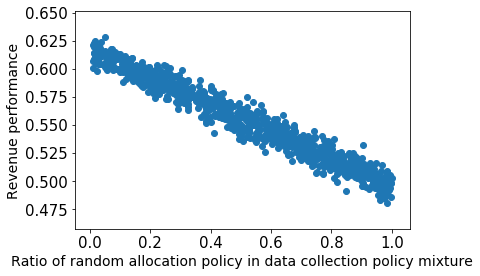

In [164]:
plt.scatter(df['params_pi1_prob'], df['values_0'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('results/revenue_synthetic_2.pdf', bbox_inches='tight')

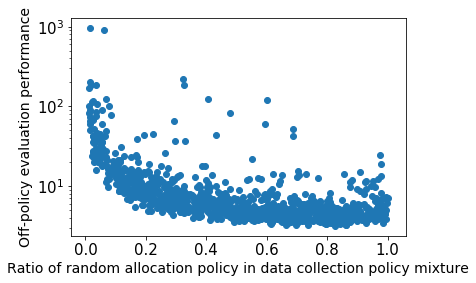

In [171]:
plt.scatter(df['params_pi1_prob'], df['values_1'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Off-policy evaluation performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.savefig('results/ope_synthetic_2.pdf', bbox_inches='tight')

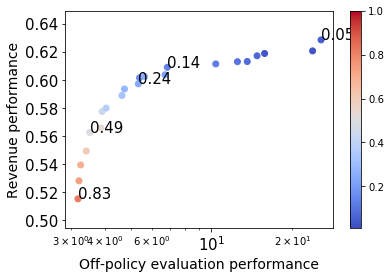

In [166]:
dominates = [False]*len(df)
values_0 = list(df['values_0'])
values_1 = list(df['values_1'])

for i in range(len(df)):
    for j in range(len(df)):
        if i == j:
            continue
        if dominates[j] == True:
            continue
        if values_0[j] >= values_0[i] and values_1[j] <= values_1[i]:
            dominates[i] = True
            break 
df['dominates'] = dominates
dom_df = df.query('dominates == False').copy()
dom_df.sort_values('values_0', inplace=True) 
dom_df.reset_index(drop=True, inplace=True)

plt.scatter(dom_df['values_1'], dom_df['values_0'], c=dom_df['params_pi1_prob'], cmap='coolwarm')
plt.clim(0.01, 1)
plt.colorbar()
plt.xlabel('Off-policy evaluation performance', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
max_idx = 0
min_idx = len(dom_df) - 1 
q1_idx = len(dom_df) // 4 - 1
q2_idx = len(dom_df) // 2 - 1
q3_idx = len(dom_df) // 4 * 3 - 1
plt.text(dom_df['values_1'][max_idx] , dom_df['values_0'][max_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][max_idx]), fontsize=15)
plt.text(dom_df['values_1'][min_idx] , dom_df['values_0'][min_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][min_idx]), fontsize=15)
plt.text(dom_df['values_1'][q1_idx] , dom_df['values_0'][q1_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q1_idx]), fontsize=15)
plt.text(dom_df['values_1'][q2_idx] , dom_df['values_0'][q2_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q2_idx]), fontsize=15)
plt.text(dom_df['values_1'][q3_idx] , dom_df['values_0'][q3_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q3_idx]), fontsize=15)
plt.savefig('results/curve_synthetic_2.pdf', bbox_inches='tight')